In [21]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from IPython.display import display, clear_output
from PIL import Image
import os

In [7]:
# Loading the face detection model 
model_path = "C:/Users/Salma/Downloads/opencv_face_detector.pbtxt"  
weights_path = "C:/Users/Salma/Downloads/opencv_face_detector_uint8.pb" 
face_net = cv2.dnn.readNetFromTensorflow(weights_path, model_path)

In [8]:
# Directory paths
input_dir = "D:/105_classes_pins_dataset" 
output_dir = "D:/cropped_faces_dataset"

In [9]:
# Ensuring the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [10]:
# Iterate through each folder and image, detecting faces
for person_name in os.listdir(input_dir):
    person_path = os.path.join(input_dir, person_name)
    if not os.path.isdir(person_path):
        continue

    # Creating a folder for each person in the output directory
    person_output_path = os.path.join(output_dir, person_name)
    if not os.path.exists(person_output_path):
        os.makedirs(person_output_path)

    # Process each image
    for image_name in os.listdir(person_path):
        image_path = os.path.join(person_path, image_name)
        image = cv2.imread(image_path)

        # Prepare image for the model
        h, w = image.shape[:2]
        blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0), swapRB=True, crop=False)
        face_net.setInput(blob)
        detections = face_net.forward()

        # Loop through detections and crop faces
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > 0.5:  # Confidence threshold
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (x1, y1, x2, y2) = box.astype("int")

                # Crop and save the detected face
                face_crop = image[y1:y2, x1:x2]
                if face_crop.size > 0:
                    face_output_path = os.path.join(person_output_path, f"face_{i}_{image_name}")
                    cv2.imwrite(face_output_path, face_crop)

In [92]:
# Base directory containing the subdirectories for each celebrity
base_dir = "D:/cropped_faces_dataset"

In [121]:
image_size = (224, 224)  

# Data splitting: Prepare train-validation split
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_data = datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 14110 images belonging to 105 classes.
Found 3471 images belonging to 105 classes.


In [94]:
# Load VGG16 with pre-trained weights
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [95]:
# freeze pretrained layers
base_model.trainable = False

In [96]:
# Add custom layers for face recognition
x = base_model.output
x = Flatten()(x)  # Using Flatten

# First dense layer with batch normalization and dropout
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)  # Optional dropout for regularization

# Second dense layer with batch normalization
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)  # Optional dropout

output_layer = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Define EarlyStopping callback to stop training if validation accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',  # Or 'val_accuracy'
    patience=3,  # Stop training after 3 epochs with no improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1
)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [97]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[early_stopping]  
)

Epoch 1/20
440/440 [==============================] - 1108s 3s/step - loss: 4.0977 - accuracy: 0.0921 - val_loss: 3.4522 - val_accuracy: 0.2106
Epoch 2/20
440/440 [==============================] - 1110s 3s/step - loss: 2.9868 - accuracy: 0.2833 - val_loss: 2.7470 - val_accuracy: 0.3478
Epoch 3/20
440/440 [==============================] - 1113s 3s/step - loss: 2.2958 - accuracy: 0.4314 - val_loss: 3.1321 - val_accuracy: 0.2697
Epoch 4/20
440/440 [==============================] - 1111s 3s/step - loss: 1.8204 - accuracy: 0.5256 - val_loss: 2.5814 - val_accuracy: 0.3600
Epoch 5/20
440/440 [==============================] - 1113s 3s/step - loss: 1.4693 - accuracy: 0.6122 - val_loss: 2.1122 - val_accuracy: 0.4806
Epoch 6/20
440/440 [==============================] - 1117s 3s/step - loss: 1.2039 - accuracy: 0.6725 - val_loss: 2.4911 - val_accuracy: 0.4144
Epoch 7/20
440/440 [==============================] - 1114s 3s/step - loss: 1.0135 - accuracy: 0.7184 - val_loss: 2.2102 - val_accuracy:

In [117]:
# Save the model using the recommended .keras format
model.save('face_recognition_model_finetunedlast_trainvgg.keras')

In [122]:
# Optional: Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-40:]:  # Unfreeze last 20 layers for fine-tuning
    layer.trainable = True

In [123]:
# Re-compile and fine-tune the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Load the entire model (architecture + weights + optimizer state)
model = tf.keras.models.load_model('face_recognition_model_finetunedlast_trainvgg.keras')

In [124]:
# Fine-tune the model with callbacks
history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[early_stopping]  
)


Epoch 1/15
440/440 [==============================] - 1104s 3s/step - loss: 1.2000 - accuracy: 0.6720 - val_loss: 2.1668 - val_accuracy: 0.4731
Epoch 2/15
440/440 [==============================] - 1108s 3s/step - loss: 1.0396 - accuracy: 0.7088 - val_loss: 2.3360 - val_accuracy: 0.4586
Epoch 3/15
440/440 [==============================] - 1110s 3s/step - loss: 0.8716 - accuracy: 0.7529 - val_loss: 2.1408 - val_accuracy: 0.5052
Epoch 4/15
440/440 [==============================] - 1109s 3s/step - loss: 0.7563 - accuracy: 0.7818 - val_loss: 2.4374 - val_accuracy: 0.4670
Epoch 5/15
440/440 [==============================] - 1108s 3s/step - loss: 0.6820 - accuracy: 0.8021 - val_loss: 2.6801 - val_accuracy: 0.4502
Epoch 6/15
440/440 [==============================] - 1111s 3s/step - loss: 0.6330 - accuracy: 0.8140 - val_loss: 2.4010 - val_accuracy: 0.4815
Epoch 6: early stopping


In [125]:
# Save the model using the recommended .keras format
model.save('face_recognition_model_finetuned_last.keras')

In [126]:
# Evaluate on the validation dataset
val_loss, val_accuracy = model.evaluate(val_data, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

109/109 [==============================] - 221s 2s/step - loss: 2.1381 - accuracy: 0.5059
Validation Loss: 2.1381
Validation Accuracy: 0.5059


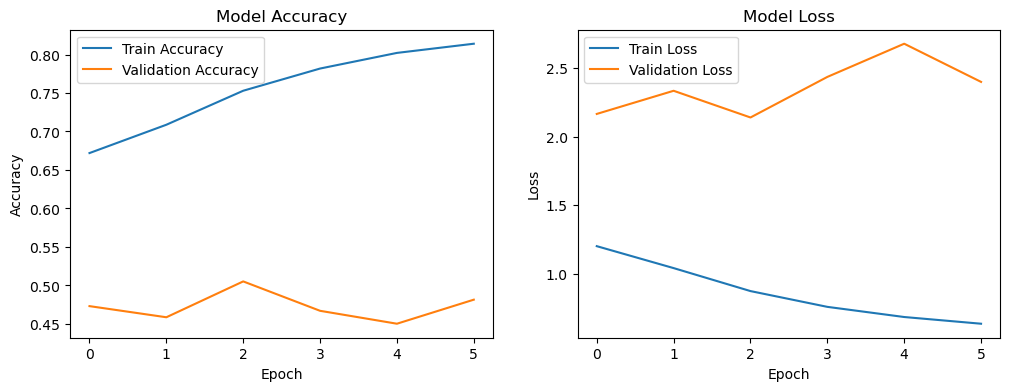

In [189]:
# Extract training history
history = history_finetune.history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [131]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get the true labels and predictions for the validation dataset
y_true = val_data.classes  # True labels
y_pred = np.argmax(model.predict(val_data), axis=-1) 

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_labels = list(val_data.class_indices.keys()) 
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:")
print(report)

109/109 [==============================] - 217s 2s/step
Confusion Matrix:
[[1 0 3 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 1 1 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 1 1 ... 0 0 1]]

Classification Report:
                             precision    recall  f1-score   support

          pins_Adriana Lima       0.02      0.02      0.02        42
          pins_Alex Lawther       0.00      0.00      0.00        30
    pins_Alexandra Daddario       0.03      0.02      0.02        45
          pins_Alvaro Morte       0.00      0.00      0.00        28
           pins_Amanda Crew       0.00      0.00      0.00        23
          pins_Andy Samberg       0.00      0.00      0.00        39
         pins_Anne Hathaway       0.05      0.03      0.03        40
        pins_Anthony Mackie       0.00      0.00      0.00        25
         pins_Avril Lavigne       0.04      0.06      0.05        32
           pins_Ben Affleck       0.00      0.00      0.00        25
            pins_Bill 

1/1 [==============================] - 0s 230ms/step


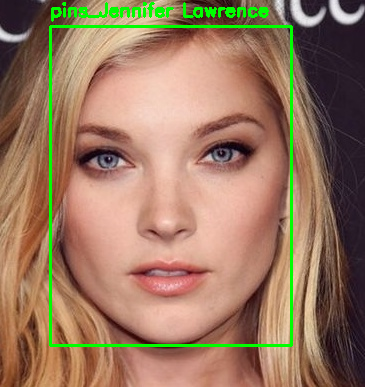

In [187]:
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from IPython.display import display
import tensorflow as tf
import pickle

# Load the pre-trained face detection model
face_model_path = "C:/Users/Salma/Downloads/opencv_face_detector.pbtxt"
weights_path = "C:/Users/Salma/Downloads/opencv_face_detector_uint8.pb"
face_net = cv2.dnn.readNetFromTensorflow(weights_path, face_model_path)

# Load the fine-tuned face recognition model
recognition_model = tf.keras.models.load_model('face_recognition_model_finetuned_last.keras')

# Load class embeddings
import pickle
with open('class_embeddings.pkl', 'rb') as f:
    class_embeddings = pickle.load(f)

# Set similarity threshold
SIMILARITY_THRESHOLD = 0.4

def detect_faces(frame):
    """Detect faces in a given frame using OpenCV's deep learning model."""
    h, w = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104, 117, 123], False, False)
    face_net.setInput(blob)
    detections = face_net.forward()
    faces = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:  # Threshold for detecting a face
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, x1, y1) = box.astype("int")
            face = frame[y:y1, x:x1]
            faces.append((face, (x, y, x1, y1)))
    return faces

def preprocess_face(face):
    """Resize and preprocess the face image for model input."""
    face = cv2.resize(face, (224, 224))  # Resize face image to the input size of the model
    face = face / 255.0  # Normalize the image
    return np.expand_dims(face, axis=0)  # Add batch dimension

def recognize_face(face_embedding):
    """Compare the face embedding to known classes and identify or classify as 'not recognized'."""
    similarities = {}
    for class_name, class_embedding in class_embeddings.items():
        sim = cosine_similarity(face_embedding, np.expand_dims(class_embedding, axis=0))[0][0]
        similarities[class_name] = sim

    # Find best match based on similarity score
    best_match = max(similarities, key=similarities.get)
    best_score = similarities[best_match]

    # Check if best score meets the similarity threshold
    if best_score >= SIMILARITY_THRESHOLD:
        return best_match
    else:
        return "not recognized"

# Function to make prediction on image and display name on bounding box
def predict_and_display(image_path):
    # Read the image
    frame = cv2.imread(image_path)
    
    # Detect faces
    faces = detect_faces(frame)
    for face, (x, y, x1, y1) in faces:
        if face.size == 0:
            continue  # Skip empty detections
        processed_face = preprocess_face(face)
        
        # Get the embedding of the face and make a prediction
        face_embedding = recognition_model.predict(processed_face)
        label = recognize_face(face_embedding)
        
        # Calculate the size of the text to avoid overflow
        font = cv2.FONT_HERSHEY_SIMPLEX
        text_size = cv2.getTextSize(label, font, 0.6, 2)[0]
        text_width, text_height = text_size
        
        # Adjust the y1 position to avoid clipping of text
        if y - text_height > 0:
            cv2.rectangle(frame, (x, y), (x1, y1), (0, 255, 0), 2)  # Draw the bounding box
            cv2.putText(frame, label, (x, y - 10), font, 0.6, (0, 255, 0), 2)  # Draw the name
        else:
            cv2.rectangle(frame, (x, y), (x1, y1), (0, 255, 0), 2)
            cv2.putText(frame, label, (x, y + text_height + 10), font, 0.6, (0, 255, 0), 2)  # Draw name below the face
    
    # Convert frame to displayable format in Jupyter notebook
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    display_frame = Image.fromarray(rgb_frame)
    
    # Display the image with detected face and name
    display(display_frame)

# Example usage - change the path to the photo you want to predict
predict_and_display("D:/105_classes_pins_dataset/pins_Natalie Dormer/Natalie Dormer79_307.jpg")


In [191]:
model = tf.keras.models.load_model('face_recognition_model_finetuned_last.keras')

# Loading the OpenCV face detection model
model_path = "C:/Users/Salma/Downloads/opencv_face_detector.pbtxt" 
weights_path = "C:/Users/Salma/Downloads/opencv_face_detector_uint8.pb" 
face_net = cv2.dnn.readNetFromTensorflow(weights_path, model_path)

# Load known class embeddings
with open('class_embeddings.pkl', 'rb') as f:
    class_embeddings = pickle.load(f)

# Set the similarity threshold
SIMILARITY_THRESHOLD = 0.5  # Adjust as necessary

def detect_faces(frame):
    """Detect faces in the frame using OpenCV's DNN model."""
    h, w = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104, 117, 123], False, False)
    face_net.setInput(blob)
    detections = face_net.forward()
    faces = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:  # Confidence threshold
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, x1, y1) = box.astype("int")
            face = frame[y:y1, x:x1]
            faces.append((face, (x, y, x1, y1)))
    return faces

def preprocess_face(face):
    """Resize and normalize face image for the VGG model."""
    face = cv2.resize(face, (224, 224))  # VGG model generally uses 224x224 input size
    face = face / 255.0  # Normalize
    return np.expand_dims(face, axis=0)

def recognize_face(face_embedding):
    """Classify face based on cosine similarity with known embeddings."""
    similarities = {}
    for class_name, class_embedding in class_embeddings.items():
        sim = cosine_similarity(face_embedding, np.expand_dims(class_embedding, axis=0))[0][0]
        similarities[class_name] = sim

    # Identify the best match based on similarity score
    best_match = max(similarities, key=similarities.get)
    best_score = similarities[best_match]

    # Classify as 'not identified' if below the threshold
    if best_score >= SIMILARITY_THRESHOLD:
        return best_match
    else:
        return "not identified"

# Start capturing video
cap = cv2.VideoCapture(0)  # '0' is the default camera

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Detect faces in the current frame
        faces = detect_faces(frame)
        for face, (x, y, x1, y1) in faces:
            if face.size == 0:
                continue  # Skip empty detections
            processed_face = preprocess_face(face)
            face_embedding = model.predict(processed_face)
            label = recognize_face(face_embedding)

            # Draw rectangle and label on the frame
            cv2.rectangle(frame, (x, y), (x1, y1), (0, 255, 0), 2)
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Display frame in Jupyter Notebook
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB for Jupyter
        display_frame = Image.fromarray(rgb_frame)
        clear_output(wait=True)
        display(display_frame)

except KeyboardInterrupt:
    pass

finally:
    # Release resources
    cap.release()
    cv2.destroyAllWindows()


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
